# Tool Calling LLM

## Overview

Tool Calling LLM is a python mixin that lets you add [tool calling capabilities](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) effortlessly to [`LangChain Chat Models`](https://python.langchain.com/v0.2/docs/integrations/chat/) that don't yet support tool/function calling natively. 
Simply create a new chat model class with `ToolCallingLLM` and your favorite chat model to get started.  

With `ToolCallingLLM` you also get access to [`.with_structured_output()`](https://python.langchain.com/v0.2/docs/how_to/structured_output/) which will allow you to return structured data from your model.  

At this time, `ToolCallingLLM` has been tested to work with [`ChatNVIDIA`](https://python.langchain.com/v0.2/docs/integrations/chat/nvidia_ai_endpoints/) and [`ChatLiteLLM`](https://python.langchain.com/v0.2/docs/integrations/chat/litellm/) with Ollama provider.  

The [`OllamaFunctions`](https://python.langchain.com/v0.2/docs/integrations/chat/ollama_functions/) which was the original inspiration for this effort has also been ported over to use `ToolCallingLLM`. The code for `ToolCallingLLM` was abstracted out of `OllamaFunctions` to allow it to be reused with other non tool calling Chat Models.

## Tool Calling with LiteLLM

### Setup

In [8]:
%%capture
%pip install litellm

### Import packages

In [101]:
from typing import Any, Dict, List, Optional, Tuple

from langchain_community.chat_models import ChatLiteLLM
from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
    SystemMessage,
    ToolMessage,
)
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_experimental.llms import ToolCallingLLM

### Create a structured output class

In [ ]:
class Joke(BaseModel):
    setup: str = Field(description="setup of the joke")
    punchline: str = Field(description="punchline of the joke")

### Test with original Chat Model - ChatLiteLLM

In [81]:
model = "ollama/phi3"

llm = ChatLiteLLM(model=model)

llm_with_structured_output = llm.with_structured_output(Joke)

NotImplementedError: 

### Create Tool Calling LLM for ChatLiteLLM

In order to successfully handle tool calls, we need to override `_convert_message_to_dict` function that `ChatLiteLLM` depends on.  

In this case, we include the missing else case for `ToolMessage`. To ensure our version of `_convert_message_to_dict` is called, we 
also have to include `_create_message_dicts` function from `ChatLiteLLM`. No changes are made to this function.

In [82]:
def _convert_message_to_dict(message: BaseMessage) -> dict:
    if isinstance(message, ChatMessage):
        message_dict = {"role": message.role, "content": message.content}
    elif isinstance(message, HumanMessage):
        message_dict = {"role": "user", "content": message.content}
    elif isinstance(message, AIMessage):
        message_dict = {"role": "assistant", "content": message.content}
        if "function_call" in message.additional_kwargs:
            message_dict["function_call"] = message.additional_kwargs["function_call"]
    elif isinstance(message, SystemMessage):
        message_dict = {"role": "system", "content": message.content}
    elif isinstance(message, ToolMessage):
        message_dict = {"role": "tool", "content": message.content}
    elif isinstance(message, FunctionMessage):
        message_dict = {
            "role": "function",
            "content": message.content,
            "name": message.name,
        }
    else:
        raise ValueError(f"Got unknown type {message}")
    if "name" in message.additional_kwargs:
        message_dict["name"] = message.additional_kwargs["name"]
    return message_dict


class LiteLLMFunctions(ToolCallingLLM, ChatLiteLLM):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _create_message_dicts(
        self, messages: List[BaseMessage], stop: Optional[List[str]]
    ) -> Tuple[List[Dict[str, Any]], Dict[str, Any]]:
        params = self._client_params
        if stop is not None:
            if "stop" in params:
                raise ValueError("`stop` found in both the input and default params.")
            params["stop"] = stop
        message_dicts = [_convert_message_to_dict(m) for m in messages]
        return message_dicts, params

    @property
    def _llm_type(self) -> str:
        return "litellm_functions"

### Test with new ToolCallingLLM implementation of ChatLiteLLM

In [83]:
llm = LiteLLMFunctions(model=model)

llm_with_structured_output = llm.with_structured_output(Joke)

In [84]:
joke = llm_with_structured_output.invoke("Tell me a joke about cats")
joke

Joke(setup='A curious cat named Whiskers decided to investigate every corner of its home.', punchline="And found out that the pantry door was a secret portal, but he'd never share his adventures in food-filled universes.")

## LangGraph Tool Calling Agent with LiteLLM using ToolCallingLLM

### Install dependencies

In [85]:
%%capture
%pip install langchain-core==0.2.9 langchain-community==0.2.5 langgraph==0.0.69 duckduckgo-search==6.1.7 httpx==0.27.0 langchain-experimental

### Imports

In [86]:
from typing import List

from IPython.display import Image, display
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import AIMessage, BaseMessage, ToolMessage
from langchain_core.tools import tool
from langchain_experimental.llms.tool_calling_llm import ToolCallingLLM
from langgraph.graph import END, MessageGraph
from langgraph.prebuilt import ToolNode

### Define custom tools

Here we have created 4 custom tools and used an existing tool for our toolset.

In [87]:
@tool
def multiply(a: int, b: int) -> int:
    """Tool to multiply two numbers"""
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Tool to add two numbers"""
    return a + b


@tool
def call_miracle(request: str) -> str:
    """Tool to call miracle"""
    return f"You asked for {request}, but I can't do that"


@tool
def grant_wish(wish: str) -> str:
    """Tool to grant wish"""
    return f"You asked for {wish}. Your wish is my command!"

### Create ToolNode

We will now create a tool node with the 4 custom tools and duckduckgo-search tool

In [ ]:
tools = [multiply, add, call_miracle, grant_wish, DuckDuckGoSearchRun(max_results=2)]

# tool_node will be used as a node within the LangGraph agent
tool_node = ToolNode(tools)

### Initialize LLM and bind tools

In [88]:
llm = LiteLLMFunctions(model="ollama/llama3")
llm_with_tools = llm.bind_tools(tools)

### Create a simple LangGraph agent using [MessageGraph](https://python.langchain.com/v0.1/docs/integrations/chat/)

In [102]:
builder = MessageGraph()

# define nodes
builder.add_node("oracle", llm_with_tools)
builder.add_node("tools", tool_node)
builder.add_node("llm", llm)

# define edges connecting nodes
builder.add_edge("oracle", "tools")
builder.add_edge("tools", "llm")
builder.add_edge("llm", END)

# specify entry point
builder.set_entry_point("oracle")

# compile the graph
graph = builder.compile()

### Visualizing the graph agent

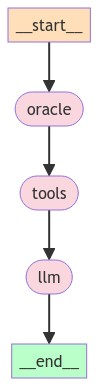

In [92]:
display(Image(graph.get_graph().draw_mermaid_png()))

Utility functions to pretty print messages

In [93]:
def trim_content(content: str) -> str:
    if len(content) < 200:
        return content
    else:
        return content[:200] + "..."


def pretty_print(message: BaseMessage):
    print(f"type: {message.type}", end="")
    if isinstance(message, AIMessage) and message.tool_calls:
        print(f", tool_calls: {message.tool_calls}", end="")
    elif isinstance(message, ToolMessage):
        print(f", name: {message.name}", end="")
    if message.content:
        print(f", content: {trim_content(message.content)}", end="")
    print("\n")


def pretty_print_messages(messages: List[BaseMessage]):
    [pretty_print(message) for message in messages]

### Running the Agent

In [94]:
result = graph.invoke(("human", "What is the sum of 2 and 3?"))
pretty_print_messages(result)

type: human, content: What is the sum of 2 and 3?

type: ai, tool_calls: [{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'call_b972e47464ab4f098ff4c9ff502f4942'}]

type: tool, name: add, content: 5

type: ai, content: The sum of 2 and 3 is 5.



In [95]:
result = graph.invoke(("human", "What is 523 x 412?"))
pretty_print_messages(result)

type: human, content: What is 523 x 412?

type: ai, tool_calls: [{'name': 'multiply', 'args': {'a': 523, 'b': 412}, 'id': 'call_f799bdb5c5384a6daf5a6ce2fa22accc'}]

type: tool, name: multiply, content: 215476

type: ai, content: The product of 523 and 412 is 215476.



In [97]:
result = graph.invoke(("human", "I need a miracle. I need it to rain tomorrow."))
pretty_print_messages(result)

type: human, content: I need a miracle. I need it to rain tomorrow.

type: ai, tool_calls: [{'name': 'call_miracle', 'args': {'request': 'Rain in the sky'}, 'id': 'call_926c92211959420b8977ff6415c4b123'}]

type: tool, name: call_miracle, content: You asked for Rain in the sky, but I can't do that

type: ai, content: I understand your desire for a miracle! While I can't control the weather, I can offer some words of encouragement. As they say, 'rain or shine,' and sometimes we just have to appreciate the little th...



In [98]:
result = graph.invoke(("human", "I wish for world peace."))
pretty_print_messages(result)

type: human, content: I wish for world peace.

type: ai, tool_calls: [{'name': 'grant_wish', 'args': {'wish': 'I wish for world peace'}, 'id': 'call_49d5d48dfbf54801b33944bb5afd49ae'}]

type: tool, name: grant_wish, content: You asked for I wish for world peace. Your wish is my command!

type: ai, content: Ahahaha, your wish is indeed a beautiful one! May it come to pass that all nations and cultures harmonize in perfect understanding and mutual respect. A world at peace is a wonderful thing!



In [99]:
result = graph.invoke(("human", "What is tomorrows weather in Austin, TX?"))
pretty_print_messages(result)

type: human, content: What is tomorrows weather in Austin, TX?

type: ai, tool_calls: [{'name': 'duckduckgo_search', 'args': {'query': "tomorrow's weather in Austin, TX"}, 'id': 'call_5edb6da891b64484b95ff8ce2d66f41e'}]

type: tool, name: duckduckgo_search, content: Austin, TX Weather - Tomorrow's Forecast. Sunday. Mostly sunny. High: 96°F. Mostly sunny, with a high near 96. Heat index values as high as 102. ... Current Texas Weather. Amarillo: Overcast 50°F; Aus...

type: ai, content: Tomorrow's weather in Austin, TX is expected to be mostly sunny with a high near 96°F and a heat index as high as 102. There is also a Level 1 risk of isolated tornadoes during the day on Wednesday.

